# e/pi0 PID CNN

In [13]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import h5py

## Visualize some e and pi0 events

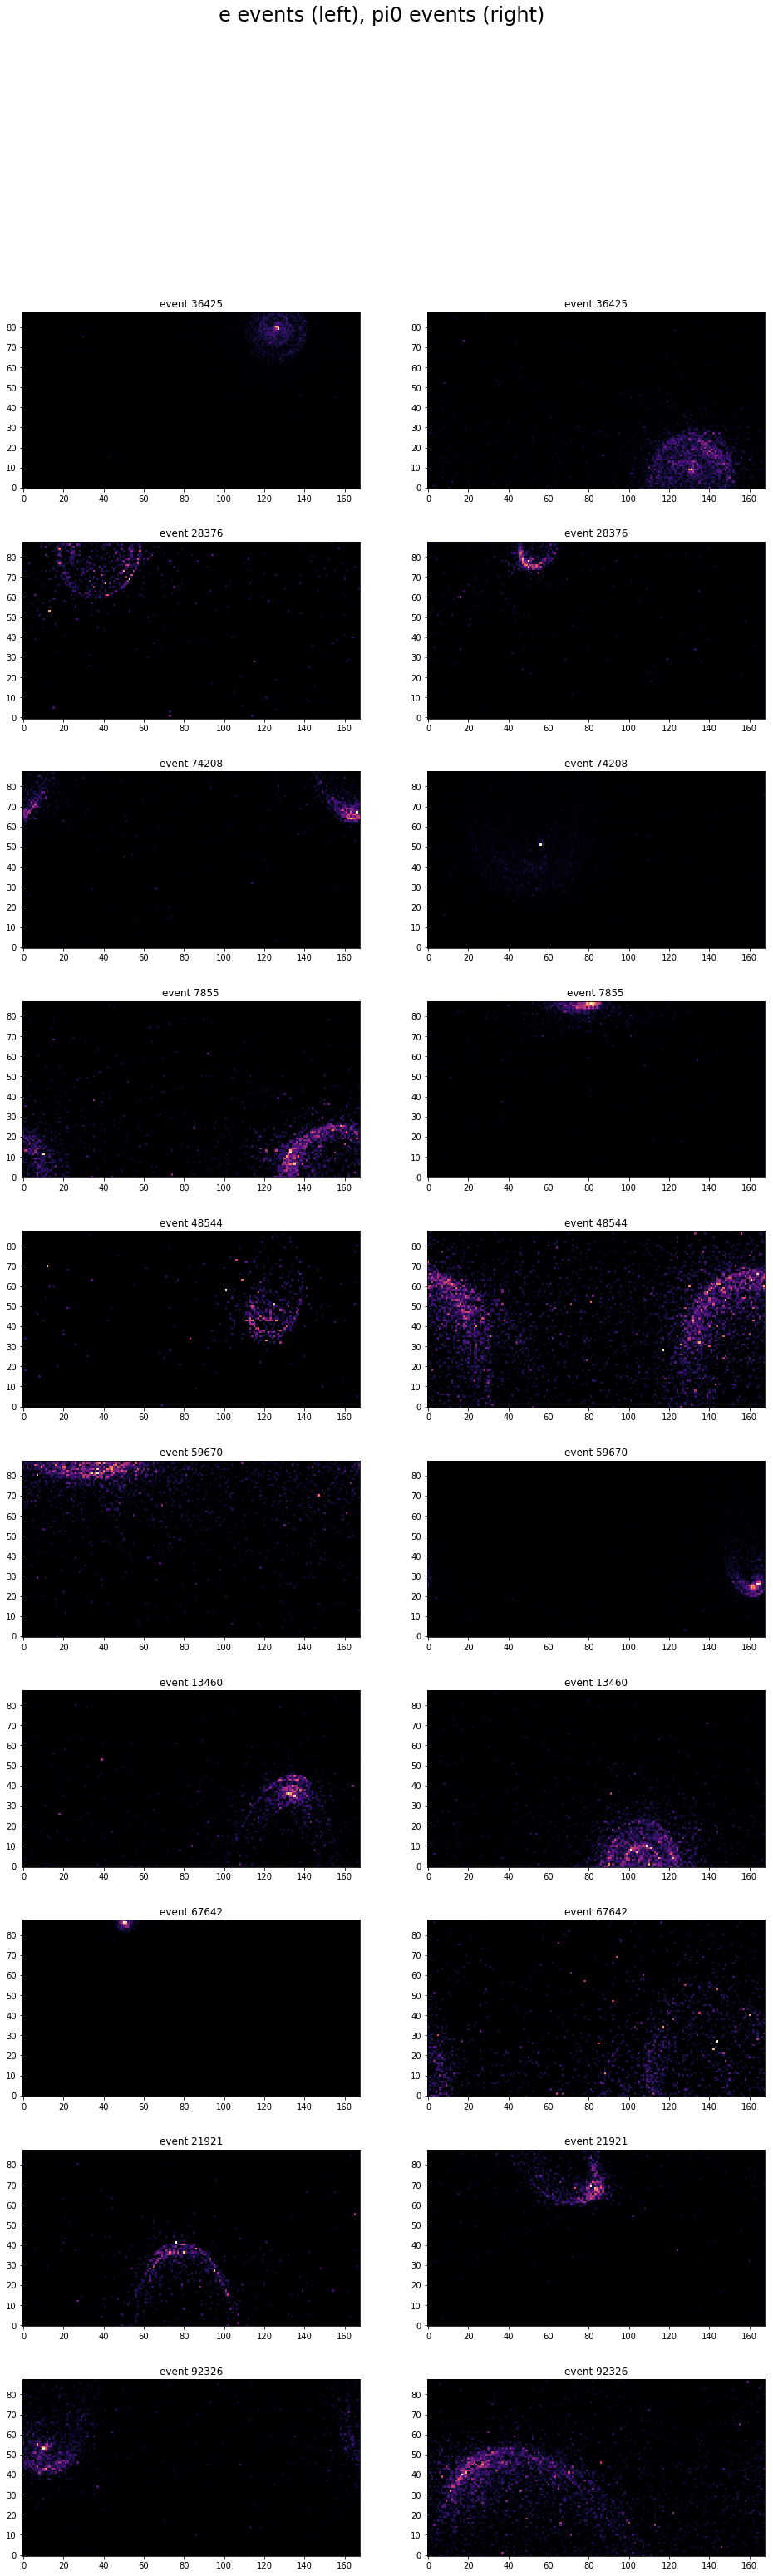

In [23]:
# Open an electron file and a pi0 file
f_e = h5py.File('/data/hkml_data/IWCDgrid/varyAll/e-/IWCDgrid_varyAll_e-_20-2000MeV_100k.h5', mode='r')
f_pi0 = h5py.File('/data/hkml_data/IWCDgrid/varyAll/pi0/IWCDgrid_varyAll_pi0_20-2000MeV_100k.h5', mode='r')

# Print some event displays
# e- events
fig,axes=plt.subplots(10,2,figsize=(16,50),facecolor='w')
fig.suptitle('e events (left), pi0 events (right)',fontsize=24)
count = 0
evt   = 0
for a in axes.flat:
    if (count % 2 == 0):
        evt = randint(0,99999)
        a.imshow(f_e['event_data'][evt,:,:,0],cmap='magma',origin='lower')
        a.set_title('event %d' % evt)
    else:
        a.imshow(f_pi0['event_data'][evt,:,:,0],cmap='magma',origin='lower')
        a.set_title('event %d' % evt)
    count += 1
plt.show()

## Defining a network
Let us define the same network similar to how we did in the [the previous example](https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20CNN%20Image%20Classification.ipynb).

In [3]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))

## Preparing a _blob_

In [4]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(2).cuda() # construct CNN for 2 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyAll/e-','/data/hkml_data/IWCDgrid/varyAll/pi0']
# transform data so that pi0 label is 0 instead of 3
def transform(result):
    if result[1]==3:
        result[1]=0
    return result
# for train
blob.train_loader=loader_factory('H5Dataset', batch_size=64,  shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.8, transform=transform)
# for validation
blob.test_loader =loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.8, use_fraction=0.2, transform=transform)

# Create & attach data recording utility (into csv file)
from utils import CSVData
blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

## Running a train loop 

In [5]:
from classification import train_loop
train_loop(blob,20.0)

Epoch 0 Starting @ 2019-04-17 15:39:53


Epoch 1 Starting @ 2019-04-17 15:42:58


Epoch 2 Starting @ 2019-04-17 15:46:02


Epoch 3 Starting @ 2019-04-17 15:49:07


Epoch 4 Starting @ 2019-04-17 15:52:12


Epoch 5 Starting @ 2019-04-17 15:55:17


Epoch 6 Starting @ 2019-04-17 15:58:23


Epoch 7 Starting @ 2019-04-17 16:01:27


Epoch 8 Starting @ 2019-04-17 16:04:33


Epoch 9 Starting @ 2019-04-17 16:07:42


Epoch 10 Starting @ 2019-04-17 16:10:51


Epoch 11 Starting @ 2019-04-17 16:14:00


Epoch 12 Starting @ 2019-04-17 16:17:05


Epoch 13 Starting @ 2019-04-17 16:20:11


Epoch 14 Starting @ 2019-04-17 16:23:16


Epoch 15 Starting @ 2019-04-17 16:26:21


Epoch 16 Starting @ 2019-04-17 16:29:27


Epoch 17 Starting @ 2019-04-17 16:32:32


Epoch 18 Starting @ 2019-04-17 16:35:37


Epoch 19 Starting @ 2019-04-17 16:38:43


## Inspecting the training process

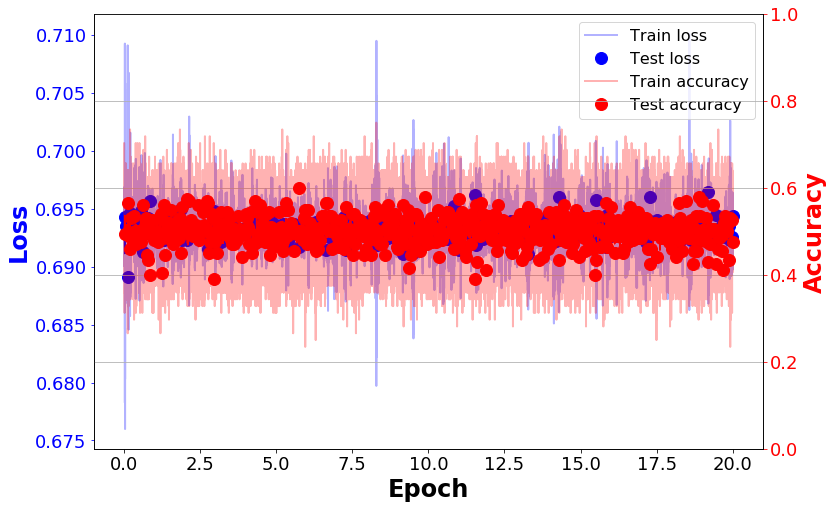

In [6]:
from classification import plot_log
plot_log(blob.train_log.name,blob.test_log.name)

## Performance Analysis

In [7]:
from classification import inference
accuracy,label,prediction = inference(blob,blob.test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())

Accuracy mean 0.5 std 0.039226905


Plot the confusion matrix

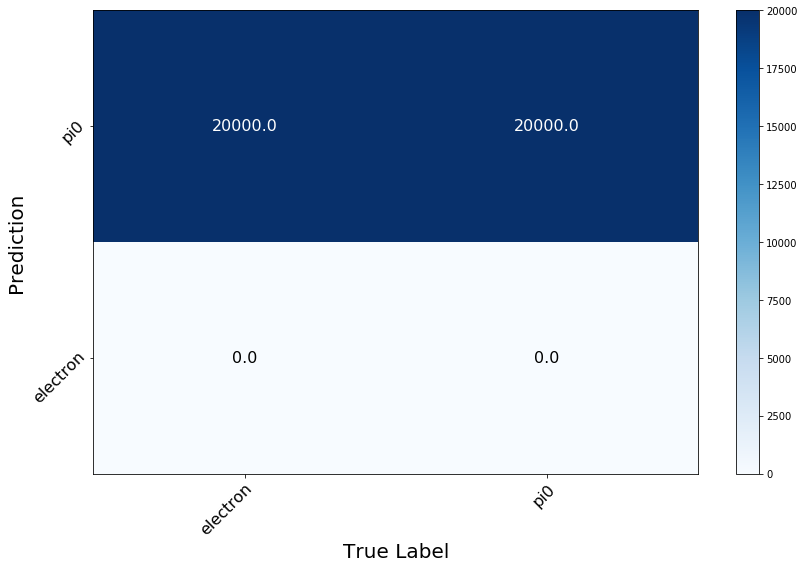

In [8]:
from utils import plot_confusion_matrix
plot_confusion_matrix(label,prediction,['pi0','electron'])